In [1]:
from keras.models import model_from_json
from keras.layers import Input, Dense
from keras.models import Model
import csv
import pandas as pd
import numpy as np
import cv2
from numpy import newaxis
from PIL import Image
from numpy import array
import glob, os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU,Activation,MaxPooling2D
from keras.layers.convolutional import Convolution2D
from numpy import random
from keras.optimizers import SGD, Adam, RMSprop
import json
import os
import h5py
from sklearn.cross_validation import train_test_split

Using TensorFlow backend.
/Users/shubhama/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .5+np.random.uniform()
#     print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

def flip_image(image,y_steer):
    if np.random.randint(2) == 0:
        image = cv2.flip(image,1)
        y_steer = -y_steer
    return image,y_steer


# This adds random shadow to the images
def add_random_shadow(image):
    top_x,top_y = 0, 320*np.random.uniform()
    bot_x,bot_y = 160, 320*np.random.uniform()
    
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    top_val = (X_m-top_x)*(bot_y-top_y)
    bot_val = (bot_x-top_x)*(Y_m-top_y)
    shadow_mask[(top_val-bot_val >= 0)] = 1

    if np.random.randint(2)==1:
        if np.random.randint(2)==1:
            image_hls[:,:,1][shadow_mask==1] = image_hls[:,:,1][shadow_mask==1]*.5
        else:
            image_hls[:,:,1][shadow_mask==0] = image_hls[:,:,1][shadow_mask==0]*.5    

    return cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)

In [14]:
file_name = 'driving_log.csv'
# data = read_data(file_name)
# data = pd.DataFrame(data)
# data

data = pd.read_csv(file_name)
data = data[0:100][:]
data.head()


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


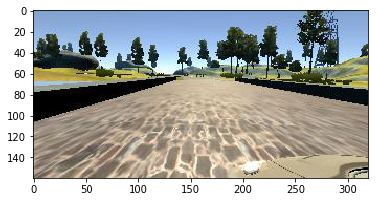

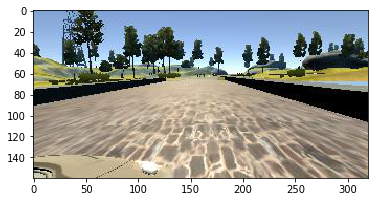

In [15]:
img = plt.imread(data['left'][0].strip())
plt.imshow(img)
plt.show()
im_left, steer = flip_image(img, 4.0)
plt.imshow(im_left)
plt.show()



In [8]:

# left_files = list(data['left'])
# right_files = list(data['right'])
# center_files = list(data['center'])

# features = ()
# labels = ()

# for i in range(data.shape[0]):
# #     im_left = plt.imread(left_files[i].strip())[65:135:4,0:-1:4,0]
# #     im_left = im_left.flatten().tolist()
# #     im_right = plt.imread(right_files[i].strip())[65:135:4,0:-1:4,0]
# #     im_right = im_right.flatten().tolist()
#     im_center = plt.imread(center_files[i].strip())[65:135:4,0:-1:4,0]
#     im_center = im_center.flatten().tolist()
# #     features = features + (im_left,)
# #     features = features + (im_right,)
#     features = features + (im_center,)

# item_num = len(features)
# print("features shape", np.array(features).shape)
# features = np.array(features).reshape(len(data), 18, 80, 1)
# print("features shape", features.shape)

# for angle in data['steering']:
#     labels = labels + (angle,)
# labels = np.array(labels)
# print('Train',features.shape,'Test',labels.shape)

In [5]:

left_files = list(data['left'])
right_files = list(data['right'])
center_files = list(data['center'])
angle = list(data['steering'])
features = ()
labels = ()

for i in range(data.shape[0]):
#     im_left = plt.imread(left_files[i].strip())[65:135:4,0:-1:4,0]
#     im_left = im_left.flatten().tolist()
#     im_right = plt.imread(right_files[i].strip())[65:135:4,0:-1:4,0]
#     im_right = im_right.flatten().tolist()
    im_center = plt.imread(center_files[i].strip())
    im_center_list = im_center[65:135:4,0:-1:4,0].flatten().tolist()
    features = features + (im_center_list,)
    labels = labels + (angle[i],)
    for j in range(20):
        im_center_tran = augment_brightness_camera_images(im_center)
        im_center_tran_list = im_center_tran[65:135:4,0:-1:4,0].flatten().tolist()
        features = features + (im_center_tran_list,)
        labels = labels + (angle[i],)
        im_center_tran = add_random_shadow(im_center)
        im_center_tran_list = im_center_tran[65:135:4,0:-1:4,0].flatten().tolist()
        features = features + (im_center_tran_list,)
        labels = labels + (angle[i],)
    
    im_center = plt.imread(left_files[i].strip())
    im_center_list = im_center[65:135:4,0:-1:4,0].flatten().tolist()
    features = features + (im_center_list,)
    labels = labels + (angle[i]+0.25,)
    for j in range(20):
        im_center_tran = augment_brightness_camera_images(im_center)
        im_center_tran_list = im_center_tran[65:135:4,0:-1:4,0].flatten().tolist()
        features = features + (im_center_tran_list,)
        labels = labels + (angle[i]+0.25,)
        im_center_tran = add_random_shadow(im_center)
        im_center_tran_list = im_center_tran[65:135:4,0:-1:4,0].flatten().tolist()
        features = features + (im_center_tran_list,)
        labels = labels + (angle[i]+0.25,)
        
    im_center = plt.imread(right_files[i].strip())
    im_center_list = im_center[65:135:4,0:-1:4,0].flatten().tolist()
    features = features + (im_center_list,)
    labels = labels + (angle[i]-0.25,)
    for j in range(20):
        im_center_tran = augment_brightness_camera_images(im_center)
        im_center_tran_list = im_center_tran[65:135:4,0:-1:4,0].flatten().tolist()
        features = features + (im_center_tran_list,)
        labels = labels + (angle[i]-0.25,)
        im_center_tran = add_random_shadow(im_center)
        im_center_tran_list = im_center_tran[65:135:4,0:-1:4,0].flatten().tolist()
        features = features + (im_center_tran_list,)
        labels = labels + (angle[i]-0.25,)

item_num = len(features)
# print("features shape", np.array(features).shape)
features = np.array(features).reshape(len(features), 18, 80, 1)
# print("features shape", features.shape)

# for angle in data['steering']:
#     labels = labels + (angle,)
#     labels = labels + (angle,)
#     labels = labels + (0.25+angle,)
#     labels = labels + (0.25+angle,)
#     labels = labels + (angle-0.25,)
#     labels = labels + (angle-0.25,)
labels = np.array(labels)
print('Train',features.shape,'LABELS',labels.shape)

Train (12300, 18, 80, 1) LABELS (12300,)


In [6]:
# X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.10,random_state=1212)
X_train, X_val, y_train, y_val = train_test_split(features,labels,test_size=0.20,random_state=1212)

train_size = X_train.shape[0]
# test_size = X_test.shape[0]
valid_size = X_val.shape[0]
input_shape = X_train.shape[1:]
features_count = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
print(features_count)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
# X_test  = X_test.astype('float32')
X_train /= 255
X_val /= 255
# X_test  /= 255
X_train -= 0.5
X_val -= 0.5
# X_test  -= 0.5

1440


In [7]:
# # Train dataset

# size = 32, 32
# i = 0
# X_train = []

# for file in data['center']:
#     img = Image.open(file)
# #     img = im.resize((32, 32), Image.ANTIALIAS)
# #     plt.imshow(im)
# #     plt.show()
    
#     img = np.array(img)
# #     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# #     img = img[..., newaxis]
# #     print(img.shape)
#     img = img/255
#     img = img - 0.5
#     X_train.append(img)
    
# # print(X_train_t)

In [8]:
input_shape = X_train.shape[1:]
print(input_shape, 'input shape')


(18, 80, 1) input shape


In [9]:
np.random.seed(1337)
batch_size = 64 # The lower the better
nb_classes = 1 # The output is a single digit: a steering angle
nb_epoch = 10 # The higher the better




In [10]:
def generate_train(data,batch_size = 32):
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            
            keep_pr = 0
            #x,y = preprocess_image_file_train(line_data)
            while keep_pr == 0:
                x,y = preprocess_image_file_train(line_data)
                pr_unif = np.random
                if abs(y)<.1:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            
            #x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            #y = np.array([[y]])
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering

In [11]:
try:
    with open('model.json', 'r') as model_json:
        model = model_from_json(json.load(model_json))

    # Use adam and mean squared error for training
    model.compile("adam", "mse")

    # import weights
    model.load_weights('model.h5')

    print("Imported model and weights")

# If the model and weights do not exist, create a new model
except:
    nb_filters1 = 16
    nb_filters2 = 8
    nb_filters3 = 4
    nb_filters4 = 2
    pool_size = (2, 2)
    kernel_size = (3, 3)
    
    model = Sequential()
    model.add(Convolution2D(nb_filters1, kernel_size[0], kernel_size[1],
                            border_mode='valid',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters2, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters3, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters4, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    
    model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 78, 16)    160         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16, 78, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 76, 8)     1160        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 14, 76, 8)     0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [12]:
print(X_train.shape)

(9840, 18, 80, 1)


In [13]:
# Compile model using Adam optimizer 
# and loss computed by mean squared error
model.compile(loss='mean_squared_error',
              optimizer=Adam(),
              metrics=['accuracy'])

### Model training
history = model.fit(X_train, y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_val, y_val))
# score = model.evaluate(X_test, y_test, verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])

Train on 9840 samples, validate on 2460 samples
Epoch 1/10
9840/9840 [==============================] - 11s - loss: 0.0320 - acc: 0.2490 - val_loss: 0.0148 - val_acc: 0.2374

In [14]:
# Save model and weights
if 'model.json' in os.listdir():
    print("the model already exists")
else:
    # Save model as json file
    json_string = model.to_json()
    with open('model.json', 'w') as outfile:
        json.dump(json_string, outfile)

    # save model weights
    model.save_weights('./model.h5')
    print("Model saved")

Model saved


In [15]:
# json_string = model.to_json()
# json.dump(json_string, open('model.json', 'wb'))
# model.save_weights('model.h5')


# # model = model_from_json(json_string)
# # weights = model.load_weights('model.h5', by_name=False)

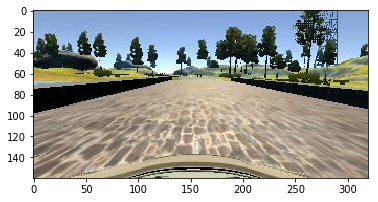

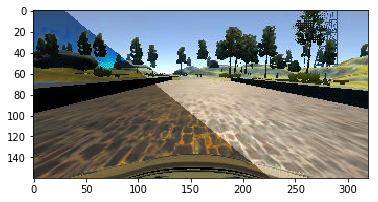

(160, 320, 3)


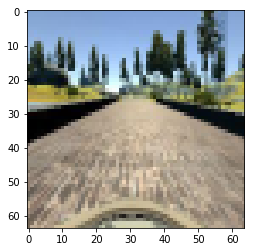

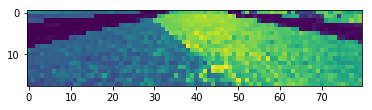

In [16]:
image = plt.imread('IMG/center_2016_12_01_13_30_48_287.jpg'.strip())
plt.imshow(image)
plt.show()
    
image1 = add_random_shadow(image)
plt.imshow(image1)
plt.show()
print(image1.shape)

new_size_col,new_size_row = 64, 64
image2 = cv2.resize(image,(new_size_col,new_size_row),interpolation=cv2.INTER_AREA)  
plt.imshow(image2)
plt.show()

image3 = image1[65:135:4,0:-1:4,0]
plt.imshow(image3)
plt.show()

In [17]:

left_files = list(data['left'])
right_files = list(data['right'])
center_files = list(data['center'])

image = plt.imread(left_files[100].strip())
plt.imshow(image)
plt.show()

image = plt.imread(center_files[100].strip())
plt.imshow(image)
plt.show()

image = plt.imread(right_files[100].strip())
plt.imshow(image)
plt.show()


print(data['steering'][100])

IndexError: list index out of range

In [ ]:
# nb_filters1 = 32
#     nb_filters2 = 64
#     nb_filters3 = 128
#     nb_filters4 = x
#     pool_size = (2, 2)
#     kernel_size = (3, 3)
    
#     model = Sequential()
#     model.add(Convolution2D(nb_filters1, kernel_size[0], kernel_size[1],
#                             border_mode='valid',input_shape=input_shape))
#     model.add(Activation('relu'))
#     model.add(Convolution2D(nb_filters2, kernel_size[0], kernel_size[1]))
#     model.add(Activation('relu'))
#     model.add(Convolution2D(nb_filters3, kernel_size[0], kernel_size[1]))
#     model.add(Activation('relu'))
#     model.add(Convolution2D(nb_filters4, kernel_size[0], kernel_size[1]))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=pool_size))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(512))
#     model.add(Activation('relu'))
#     model.add(Dense(64))
#     model.add(Activation('relu'))
#     model.add(Dense(16))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.35))
#     model.add(Dense(nb_classes))
    
#     model.summary()